# FFT Performance on CPU vs GPU

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import time

print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

CUDA available: True
CUDA device: Orin


Image shape: (1024, 1024)


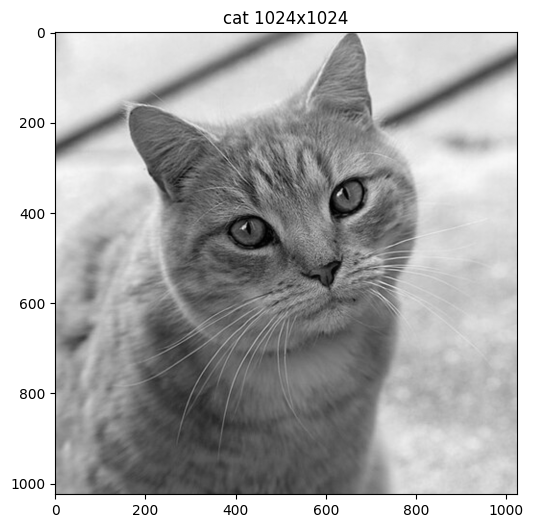

In [2]:
image_size = 1024

img = Image.open("cat.jpg").convert('L')
img = img.resize((image_size, image_size))
image_array = np.array(img).astype(np.float32)

print(f"Image shape: {image_array.shape}")
plt.figure(figsize=(6, 6))
plt.imshow(image_array, cmap='gray')
plt.title(f"cat {image_size}x{image_size}")
plt.show()

In [3]:
# convert to torch tensors
image_tensor = torch.from_numpy(image_array).float()
image_cpu = image_tensor.clone()
if torch.cuda.is_available():
    image_gpu = image_tensor.cuda()
    print("Created a GPU tensor")
else:
    print("CUDA not available, GPU skipped")
    image_gpu = None

Created a GPU tensor


In [4]:
def apply_fft_2d(image_tensor):
    fft_result = torch.fft.fft2(image_tensor)
    fft_shifted = torch.fft.fftshift(fft_result)
    magnitude_spectrum = torch.abs(fft_shifted) 
    return fft_shifted, magnitude_spectrum

def apply_inverse_fft_2d(fft_shifted): #inverse 2d FFT
    fft_result = torch.fft.ifftshift(fft_shifted)
    reconstructed = torch.fft.ifft2(fft_result)
    reconstructed_real = torch.real(reconstructed)
    return reconstructed_real

In [5]:
_ = apply_fft_2d(image_cpu)
# benchmarking values
num_iterations = 10
cpu_times = []
print("Running CPU tests/benchmarks...")
for i in range(num_iterations):
    start_time = time.time()
    fft_shifted_cpu, magnitude_cpu = apply_fft_2d(image_cpu)
    reconstructed_cpu = apply_inverse_fft_2d(fft_shifted_cpu)
    end_time = time.time()
    
    elapsed = (end_time - start_time) * 1000 
    cpu_times.append(elapsed)
    print(f"Iteration {i+1}/{num_iterations}, {elapsed:.2f} ms")

cpu_mean = np.mean(cpu_times)
cpu_std = np.std(cpu_times)

print(f"CPU performance:")
print(f"Mean: {cpu_mean:.2f} ms")
print(f"Std:  {cpu_std:.2f} ms")

Running CPU tests/benchmarks...
Iteration 1/10, 88.33 ms
Iteration 2/10, 78.28 ms
Iteration 3/10, 77.77 ms
Iteration 4/10, 80.65 ms
Iteration 5/10, 75.67 ms
Iteration 6/10, 73.62 ms
Iteration 7/10, 76.71 ms
Iteration 8/10, 80.89 ms
Iteration 9/10, 73.60 ms
Iteration 10/10, 72.58 ms
CPU performance:
Mean: 77.81 ms
Std:  4.44 ms


In [6]:
if torch.cuda.is_available() and image_gpu is not None:
    _ = apply_fft_2d(image_gpu)
    torch.cuda.synchronize()
    gpu_times = []
    
    for i in range(num_iterations):
        torch.cuda.synchronize()
        start_time = time.time()
        
        fft_shifted_gpu, magnitude_gpu = apply_fft_2d(image_gpu)
        reconstructed_gpu = apply_inverse_fft_2d(fft_shifted_gpu)
        
        torch.cuda.synchronize()
        end_time = time.time()
        
        elapsed = (end_time - start_time) * 1000 
        gpu_times.append(elapsed)
        print(f"iteration {i+1}/{num_iterations}: {elapsed:.2f} ms")
    
    gpu_mean = np.mean(gpu_times)
    gpu_std = np.std(gpu_times)
    
    print(f"GPU Mean: {gpu_mean:.2f} ms\nStdev: {gpu_std:.2f} ms")
    
    speedup = cpu_mean / gpu_mean
    print(f"Speedup: {speedup:.2f}x")
else:
    print("GPU unavailable, skipping GPU tests")
    gpu_times = None
    gpu_mean = None
    gpu_std = None

iteration 1/10: 7.52 ms
iteration 2/10: 6.98 ms
iteration 3/10: 6.85 ms
iteration 4/10: 6.78 ms
iteration 5/10: 6.78 ms
iteration 6/10: 6.71 ms
iteration 7/10: 4.88 ms
iteration 8/10: 3.52 ms
iteration 9/10: 3.54 ms
iteration 10/10: 3.50 ms
GPU Mean: 5.71 ms
Stdev: 1.57 ms
Speedup: 13.64x


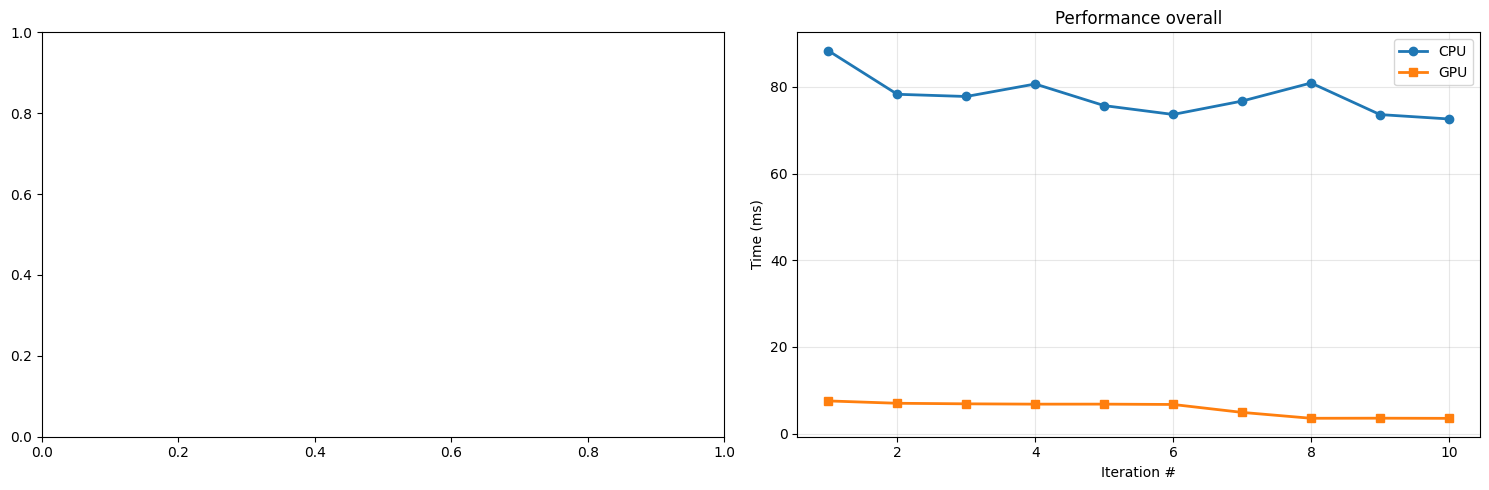

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
iterations = range(1, num_iterations + 1)
axes[1].plot(iterations, cpu_times, 'o-', label='CPU', linewidth=2, markersize=6)
if gpu_times is not None:
    axes[1].plot(iterations, gpu_times, 's-', label='GPU', linewidth=2, markersize=6)
axes[1].set_xlabel('Iteration #')
axes[1].set_ylabel('Time (ms)')
axes[1].set_title('Performance overall')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

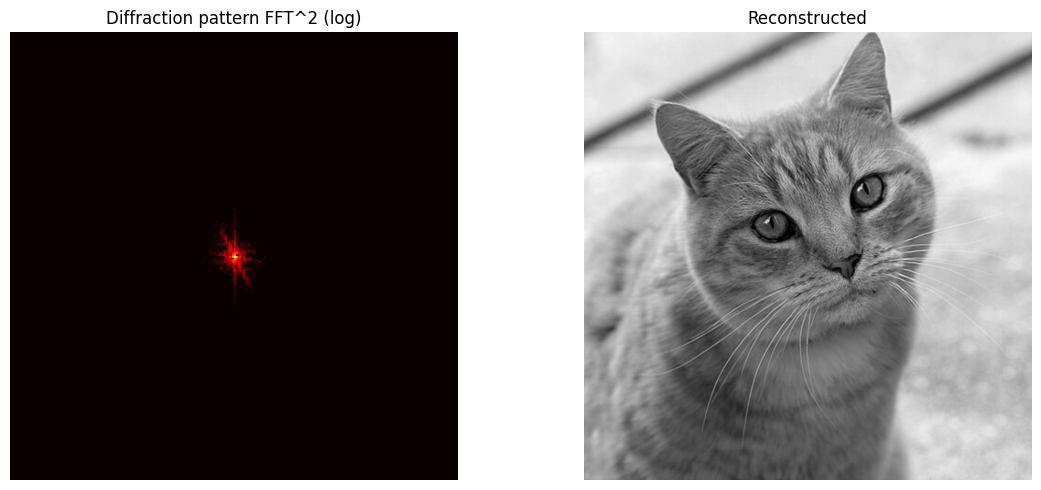

Reconstruction error MAE: 0.000009


In [8]:
intensity = (magnitude_cpu ** 2)
intensity = intensity / intensity.max()
center = image_size // 2
zoom = image_size // 8
intensity_zoomed = intensity[center-zoom:center+zoom, center-zoom:center+zoom]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(np.log10(intensity_zoomed.numpy() + 1e-10), cmap='hot', vmin=-5, vmax=0)
axes[0].set_title('Diffraction pattern FFT^2 (log)')
axes[0].axis('off')

axes[1].imshow(reconstructed_cpu.numpy(), cmap='gray')
axes[1].set_title('Reconstructed') # inverse fft
axes[1].axis('off')

plt.tight_layout()
plt.show()

reconstruction_error = torch.mean(torch.abs(image_cpu - reconstructed_cpu))
print(f"Reconstruction error MAE: {reconstruction_error:.6f}")

In [9]:
sizes = [256, 512, 1024, 2048, 4096]
cpu_results = []
gpu_results = []

for size in sizes:    
    img = Image.open("cat.jpg").convert('L').resize((size, size))
    test_tensor_cpu = torch.from_numpy(np.array(img).astype(np.float32))
    
    _ = apply_fft_2d(test_tensor_cpu)
    start = time.time()
    for _ in range(5):
        fft_result, _ = apply_fft_2d(test_tensor_cpu)
        _ = apply_inverse_fft_2d(fft_result)
    cpu_time = (time.time() - start) * 1000 / 5
    cpu_results.append(cpu_time)
    print(f"CPU{cpu_time:.2f} ms")
    
    if torch.cuda.is_available():
        test_tensor_gpu = test_tensor_cpu.cuda()
        _ = apply_fft_2d(test_tensor_gpu)
        torch.cuda.synchronize()
        
        start = time.time()
        for _ in range(5):
            fft_result, _ = apply_fft_2d(test_tensor_gpu)
            _ = apply_inverse_fft_2d(fft_result)
        torch.cuda.synchronize()
        gpu_time = (time.time() - start) * 1000 / 5
        gpu_results.append(gpu_time)
        print(f"GPU: {gpu_time:.2f} ms\nSpeedup: {cpu_time/gpu_time:.2f}x")
    print()

CPU8.35 ms
GPU: 0.79 ms
Speedup: 10.52x

CPU22.36 ms
GPU: 1.86 ms
Speedup: 12.05x



CPU80.49 ms
GPU: 6.71 ms
Speedup: 11.99x

CPU322.61 ms
GPU: 18.09 ms
Speedup: 17.84x

CPU1293.57 ms
GPU: 89.73 ms
Speedup: 14.42x

